<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session5_normalization/backup/5_normalization_singlefile_scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Code


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import random

### Data transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation(fill=(0,),degrees=(-7,7)), 
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

##### Dataset and creating test and train data

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

### Visualizing the dataset

### Dataloader arguments and test/ train dataloaders

In [4]:
SEED = 1
dropout_value = 0

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Model

In [5]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Net(nn.Module):
    def __init__(self, normalization_type = "Batch", group_num = 0):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = self.convolution_layer (1, 8, 3, normalization_type, group_num)
        # CONVOLUTION BLOCK 
        self.convblock2 = self.convolution_layer (8, 24,  3, normalization_type, group_num)

        # TRANSITION BLOCK 
        self.transblock1 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=18, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
        ) # ip = 24 | op = 24 | RF = 
        self.pool1 = nn.MaxPool2d(2, 2) # ip = 24 | op = 12 | RF =

        # CONVOLUTION BLOCK 
        self.convblock3 = self.convolution_layer (18, 16,  3, normalization_type, group_num)
        

        # CONVOLUTION BLOCK 
        self.convblock4 = self.convolution_layer (16, 16,  3, normalization_type, group_num)
      

        # CONVOLUTION BLOCK
        self.convblock5 = self.convolution_layer (16, 16,  3, normalization_type, group_num)
        
        # GAP layer
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # ip = | op = | RF = 

        self.transblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # ip = 4 | op = 4 | RF = 

    def batchnormalization(self, output_channel_size, normalization_type = "Batch", group_num=0):
      if normalization_type == "Batch":
        return nn.BatchNorm2d(output_channel_size)
      elif normalization_type == "Layer": # https://pytorch.org/docs/stable/generated/torch.nn.GroupNorm.html
        return nn.GroupNorm(1, output_channel_size)
      elif normalization_type == "Group":
        return nn.GroupNorm(group_num, output_channel_size)

    def convolution_layer (self, input, output, kernel_val=3, normalization_type="Batch", group_num=0, dropout_val=0):
        layer = nn.Sequential(
                  nn.Conv2d(in_channels=input, out_channels=output, kernel_size=(kernel_val, kernel_val), padding=0, bias=False),
                  nn.ReLU(),
                  self.batchnormalization(output, normalization_type, group_num),
                  nn.Dropout(dropout_value)
                )  
        return layer


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transblock1(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = self.transblock2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model parameters

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           1,728
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 18, 24, 24]             432
             ReLU-10           [-1, 18, 24, 24]               0
        MaxPool2d-11           [-1, 18, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           2,592

# Displaying misclassified images

In [7]:
def test_missclassified(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        model.eval()
        output = model(data)
        loss = F.nll_loss(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
    return true,pred,image,true_wrong,pred_wrong

In [8]:
# show misclassified images
def wrong_plot(n_figures,true,ima,pred, norm):
    print ("Normalization technique: ", norm)
    #n_row = int(n_figures/3)
    plt.figure(figsize = (20, 10))
    for r in range(n_figures):
      a = random.randint(0,len(true)-1)  
      image,correct,wrong = ima[a],true[a],pred[a]
      img_tensor = torch.from_numpy(image).unsqueeze(0).to(device)
      image = torch.from_numpy(image).squeeze()
      #correct = int(correct)
      #wrong = int(wrong)
      f = 'Actual:'+str(int(correct)) + ',' +'Predicted:'+str(int(wrong))
      image = image.numpy()
      
      plt.subplot(2,5,r+1)    # the number of images in the grid is 5*5 (25)
      im = plt.imshow(image)
      plt.title(f)
    plt.show()

### Training and testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, l_val, train_losses, train_acc):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # L1 normalization
    if l_val > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + l_val*l1
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

### Train and test our model (step size = 6)

---



In [10]:
def run_model(model, device, train_loader, test_loader, l_val):
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

  EPOCHS = 20

  for epoch in range (EPOCHS):
     print("EPOCH:", epoch+1)
     train(model, device, train_loader, optimizer, l_val, train_losses, train_acc)
     scheduler.step()
     test(model, device, test_loader, test_losses, test_acc)  

  return train_losses, train_acc, test_losses, test_acc

Normalization type:  Batch
EPOCH: 1


Loss=1.7126049995422363 Batch_id=468 Accuracy=87.13: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]



Test set: Average loss: 0.4557, Accuracy: 8900/10000 (89.00%)

EPOCH: 2


Loss=1.1601179838180542 Batch_id=468 Accuracy=93.90: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]



Test set: Average loss: 0.4276, Accuracy: 8887/10000 (88.87%)

EPOCH: 3


Loss=1.0785216093063354 Batch_id=468 Accuracy=93.47: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]



Test set: Average loss: 0.9208, Accuracy: 7104/10000 (71.04%)

EPOCH: 4


Loss=1.1176905632019043 Batch_id=468 Accuracy=93.63: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]



Test set: Average loss: 0.5383, Accuracy: 8402/10000 (84.02%)

EPOCH: 5


Loss=1.1622653007507324 Batch_id=468 Accuracy=93.77: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s]



Test set: Average loss: 1.8238, Accuracy: 5931/10000 (59.31%)

EPOCH: 6


Loss=1.0576343536376953 Batch_id=468 Accuracy=93.73: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]



Test set: Average loss: 0.3751, Accuracy: 8785/10000 (87.85%)

EPOCH: 7


Loss=0.7081200480461121 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:18<00:00, 24.78it/s]



Test set: Average loss: 0.2112, Accuracy: 9433/10000 (94.33%)

EPOCH: 8


Loss=0.6988781690597534 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]



Test set: Average loss: 0.1379, Accuracy: 9628/10000 (96.28%)

EPOCH: 9


Loss=0.7016391754150391 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]



Test set: Average loss: 0.2301, Accuracy: 9361/10000 (93.61%)

EPOCH: 10


Loss=0.7036967873573303 Batch_id=468 Accuracy=96.49: 100%|██████████| 469/469 [00:17<00:00, 26.60it/s]



Test set: Average loss: 0.1504, Accuracy: 9587/10000 (95.87%)

EPOCH: 11


Loss=0.6596378087997437 Batch_id=468 Accuracy=96.54: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s]



Test set: Average loss: 0.1230, Accuracy: 9688/10000 (96.88%)

EPOCH: 12


Loss=0.7105838060379028 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]



Test set: Average loss: 0.1738, Accuracy: 9501/10000 (95.01%)

EPOCH: 13


Loss=0.6066449880599976 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]



Test set: Average loss: 0.0788, Accuracy: 9825/10000 (98.25%)

EPOCH: 14


Loss=0.6264593601226807 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]



Test set: Average loss: 0.0794, Accuracy: 9834/10000 (98.34%)

EPOCH: 15


Loss=0.6522443294525146 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]



Test set: Average loss: 0.0764, Accuracy: 9842/10000 (98.42%)

EPOCH: 16


Loss=0.663791298866272 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:17<00:00, 26.65it/s]



Test set: Average loss: 0.0773, Accuracy: 9836/10000 (98.36%)

EPOCH: 17


Loss=0.68157958984375 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]



Test set: Average loss: 0.0810, Accuracy: 9816/10000 (98.16%)

EPOCH: 18


Loss=0.6594368815422058 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]



Test set: Average loss: 0.0851, Accuracy: 9812/10000 (98.12%)

EPOCH: 19


Loss=0.6339744329452515 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]



Test set: Average loss: 0.0740, Accuracy: 9844/10000 (98.44%)

EPOCH: 20


Loss=0.6693905591964722 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:17<00:00, 26.39it/s]



Test set: Average loss: 0.0726, Accuracy: 9846/10000 (98.46%)

Normalization technique:  Batch


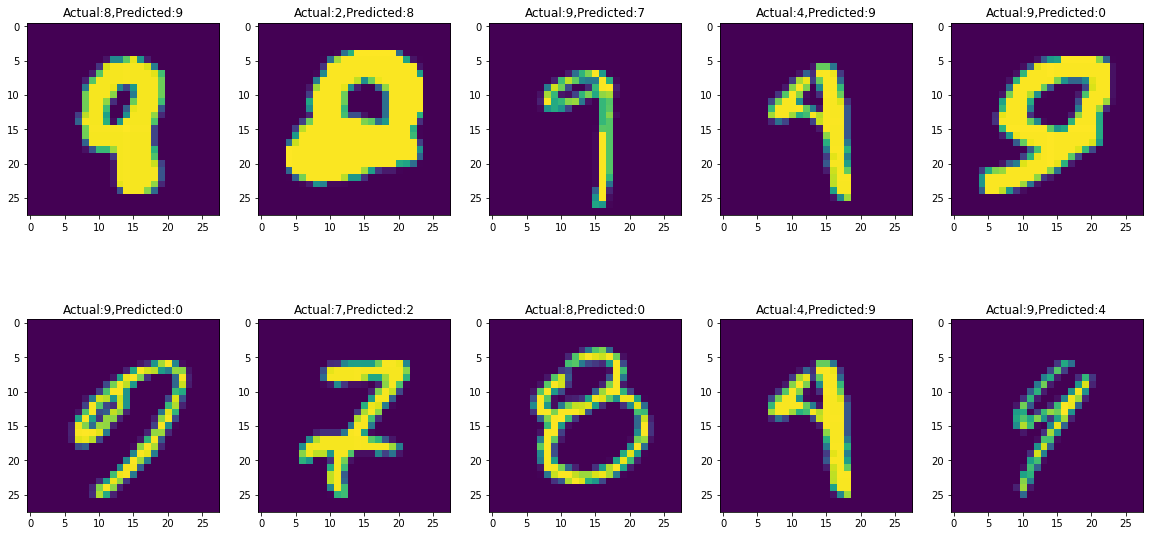



Normalization type:  Layer
EPOCH: 1


Loss=0.11034958809614182 Batch_id=468 Accuracy=86.73: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]



Test set: Average loss: 0.0962, Accuracy: 9770/10000 (97.70%)

EPOCH: 2


Loss=0.030553651973605156 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:16<00:00, 27.67it/s]



Test set: Average loss: 0.0585, Accuracy: 9848/10000 (98.48%)

EPOCH: 3


Loss=0.03252578154206276 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0476, Accuracy: 9865/10000 (98.65%)

EPOCH: 4


Loss=0.04228583350777626 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]



Test set: Average loss: 0.0421, Accuracy: 9877/10000 (98.77%)

EPOCH: 5


Loss=0.02558843232691288 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]



Test set: Average loss: 0.0435, Accuracy: 9867/10000 (98.67%)

EPOCH: 6


Loss=0.05542841553688049 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]



Test set: Average loss: 0.0324, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


Loss=0.054848264902830124 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]



Test set: Average loss: 0.0255, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.02794981561601162 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]



Test set: Average loss: 0.0258, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.029376817867159843 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 27.11it/s]



Test set: Average loss: 0.0252, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.051538437604904175 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 27.29it/s]



Test set: Average loss: 0.0250, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.02791629172861576 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]



Test set: Average loss: 0.0247, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.007429004181176424 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]



Test set: Average loss: 0.0259, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.022147120907902718 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]



Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.0033703160006552935 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:17<00:00, 27.29it/s]



Test set: Average loss: 0.0241, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.004055196885019541 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.006543159019201994 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.26%)

EPOCH: 17


Loss=0.01468032505363226 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]



Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.00611400231719017 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]



Test set: Average loss: 0.0242, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss=0.009215299040079117 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]



Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.013200145214796066 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]



Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

Normalization technique:  Layer


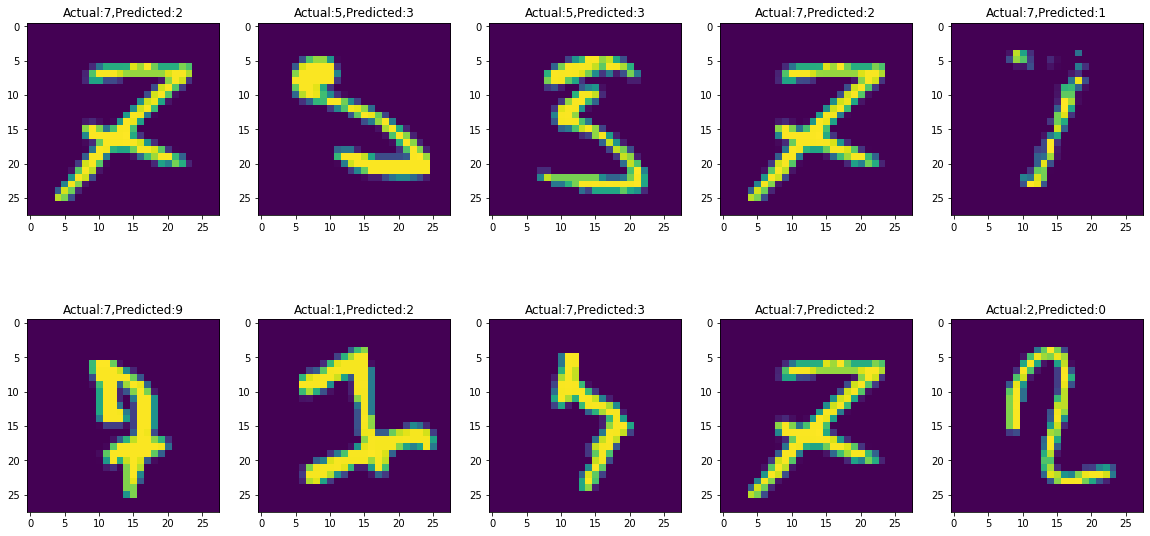



Normalization type:  Group
EPOCH: 1


Loss=0.05995025858283043 Batch_id=468 Accuracy=85.39: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]



Test set: Average loss: 0.1032, Accuracy: 9730/10000 (97.30%)

EPOCH: 2


Loss=0.07484123855829239 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]



Test set: Average loss: 0.0620, Accuracy: 9825/10000 (98.25%)

EPOCH: 3


Loss=0.05794182047247887 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]



Test set: Average loss: 0.0417, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.01950985938310623 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]



Test set: Average loss: 0.0497, Accuracy: 9851/10000 (98.51%)

EPOCH: 5


Loss=0.048660386353731155 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]



Test set: Average loss: 0.0362, Accuracy: 9887/10000 (98.87%)

EPOCH: 6


Loss=0.050176605582237244 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 26.91it/s]



Test set: Average loss: 0.0338, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.07131302356719971 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s]



Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.01021797489374876 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]



Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.02137516625225544 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:18<00:00, 25.58it/s]



Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.03425223007798195 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s]



Test set: Average loss: 0.0253, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.042457595467567444 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]



Test set: Average loss: 0.0253, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.005971315782517195 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]



Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.07360679656267166 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]



Test set: Average loss: 0.0247, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.005238575395196676 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]



Test set: Average loss: 0.0245, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Loss=0.021508678793907166 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]



Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.019165528938174248 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]



Test set: Average loss: 0.0245, Accuracy: 9922/10000 (99.22%)

EPOCH: 17


Loss=0.003805914195254445 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]



Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 18


Loss=0.005839398596435785 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]



Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)

EPOCH: 19


Loss=0.04206874966621399 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:18<00:00, 25.33it/s]



Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

EPOCH: 20


Loss=0.06955934315919876 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]



Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)

Normalization technique:  Group


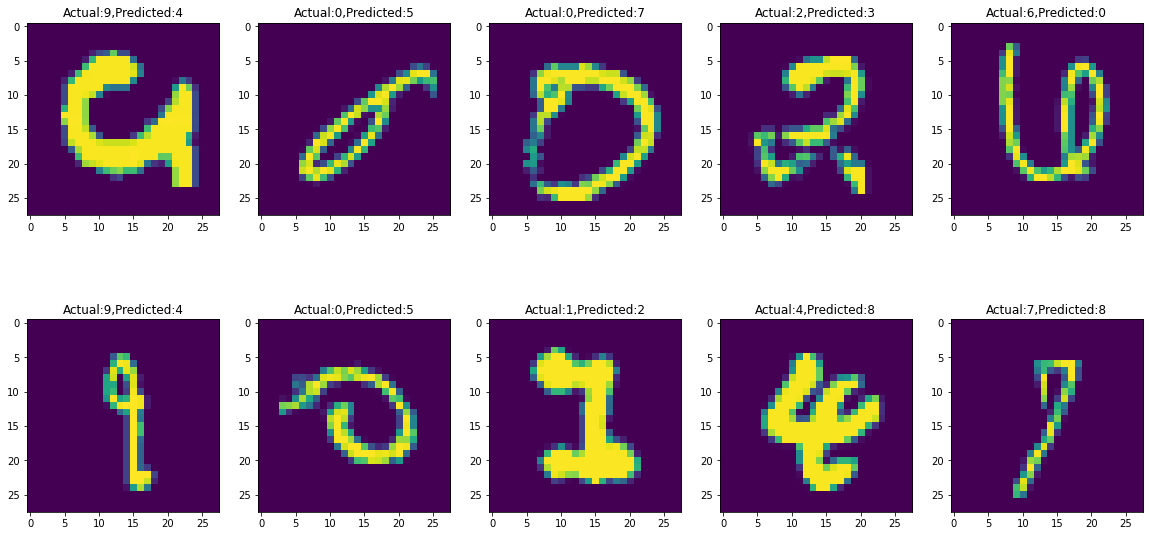

In [11]:
normalization_iter = ["Batch", "Layer", "Group"]
num_of_groups_iter = [0, 0, 4]
lambda_val = [0.01, 0, 0]

train_losses_all=[]
train_acc_all=[]
test_losses_all=[]
test_acc_all=[]

for (norm, no_gps, l_val) in zip(normalization_iter, num_of_groups_iter, lambda_val):
  print ("Normalization type: ", norm)
  model =  Net(normalization_type=norm, group_num = no_gps).to(device) 
  train_losses, train_acc, test_losses, test_acc = run_model(model, device, train_loader, test_loader, l_val)
  train_losses_all.append(train_losses)
  train_acc_all.append(train_acc)
  test_losses_all.append(test_losses)
  test_acc_all.append(test_acc)
  true,pred,image,true_wrong,pred_wrong = test_missclassified(test_loader)
  wrong_plot(10,true_wrong,image,pred_wrong, norm)
  print ("\n")

### Plotting

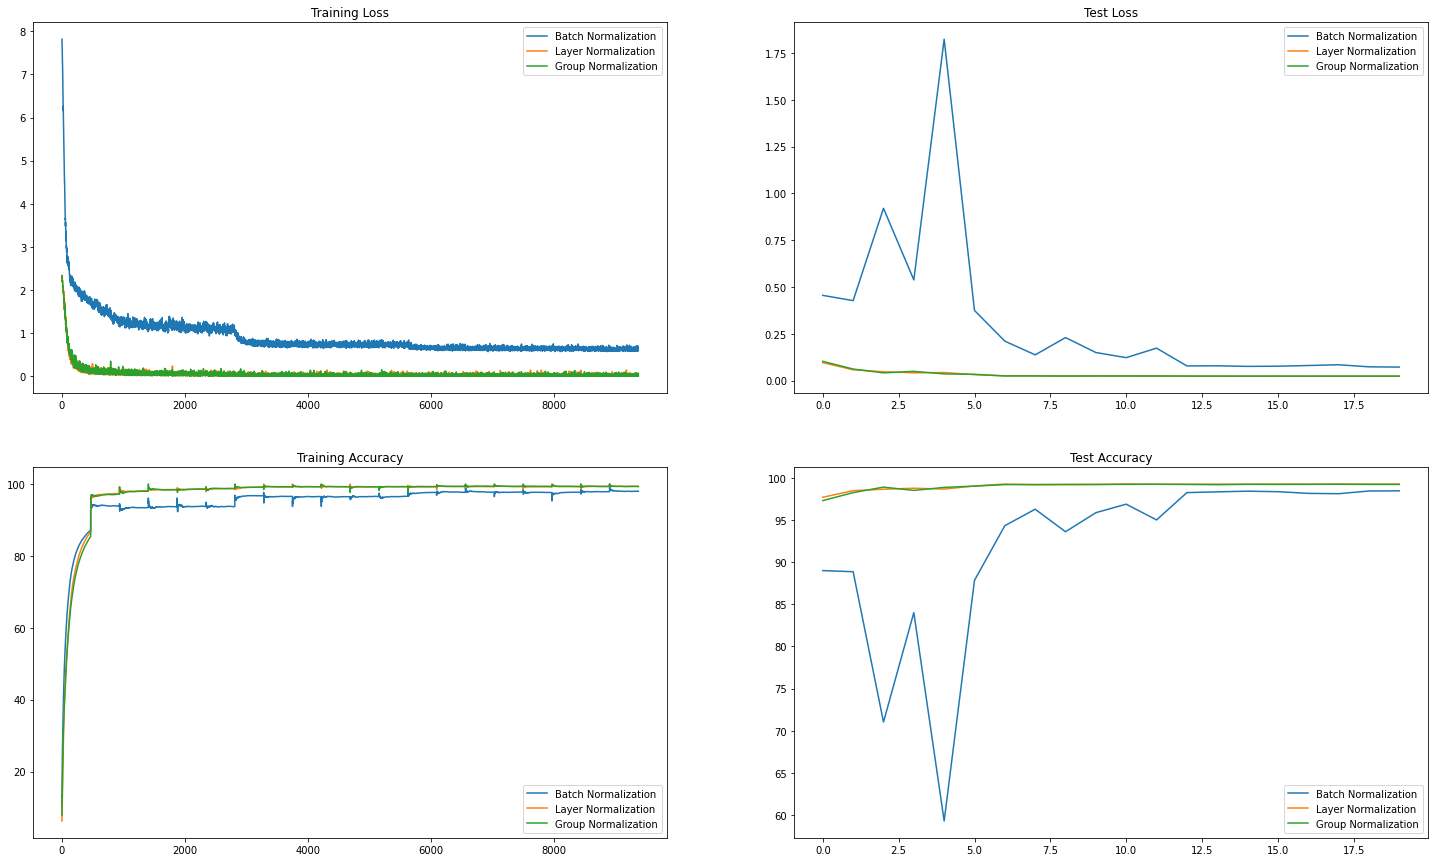

In [12]:
fig, axs = plt.subplots(2,2,figsize=(25,15))
for i, norm_type in enumerate(normalization_iter):

      axs[0, 0].set_title("Training Loss")
      axs[1, 0].set_title("Training Accuracy")
      axs[0, 1].set_title("Test Loss")
      axs[1, 1].set_title("Test Accuracy")

      axs[0, 0].plot(train_losses_all[i], label = norm_type + " Normalization")
      axs[0,0].legend(loc='upper right')
  

      axs[1, 0].plot(train_acc_all[i], label = norm_type + " Normalization")
      axs[1,0].legend(loc='lower right')


      axs[0, 1].plot(test_losses_all[i], label = norm_type + " Normalization")
      axs[0,1].legend(loc='upper right')


      axs[1, 1].plot(test_acc_all[i], label = norm_type + " Normalization")
      axs[1,1].legend(loc='lower right')